<a href="https://colab.research.google.com/github/rtheman/CLV/blob/master/Video_Similarities_naive_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.) Set environments and libraries

## a. Import libraries

In [1]:
pip install imagehash

     |████████████████████████████████| 296kB 2.7MB/s 
  Created wheel for imagehash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=291990 sha256=dc384f5b6cb10f555e990c735672b2747a8e031598ceedbac272383686a9bcf1
  Stored in directory: /root/.cache/pip/wheels/07/1c/dc/6831446f09feb8cc199ec73a0f2f0703253f6ae013a22f4be9
Successfully built imagehash


In [2]:
import imagehash

# via Pillow library
from PIL import Image, ImageShow
from google.colab.patches import cv2_imshow

## b. Set path to videos (origin)

In [3]:
import os

# Videos Origin
data_path = "/content/drive/My Drive/Colab Notebooks/data/RedBull/Proj_Creatives/"

# OG_video = "Crossfit-Female.mp4"
# OG_video = "Soapboxrace.mp4"
OG_video = "UCI.mp4"

video_fullpath = os.path.join(data_path, OG_video)

## c. Set path to extracted frames (destination)

In [4]:
extracted_frames_directory = "/content/drive/My Drive/Colab Notebooks/data/RedBull/Proj_Creatives"

video_types = [".3g2", ".3gp", ".asf", ".asx", ".avi", ".flv", \
               ".m2ts", ".mkv", ".mov", ".mp4", ".mpg", ".mpeg", \
               ".rm", ".swf", ".vob", ".wmv"]

# Functions

## (func A.)  Extract & Saving Video Frames

In [5]:
import cv2

def Video_to_Frames(video_fullpath):
    # Set path of originating video
    Video_filename_w_extension = os.path.basename(video_fullpath)
    Video_filename = os.path.splitext(Video_filename_w_extension)[0]

    # Set path of destination for extracted frames (from video)
    Extracted_Frames_fullpath = os.path.join(extracted_frames_directory, Video_filename)

    # create new directory per video
    if not os.path.exists(Extracted_Frames_fullpath):
        os.makedirs(Extracted_Frames_fullpath)

    # Extract video from origination filepath (using `CV2`)
    VidCap = cv2.VideoCapture(video_fullpath)

    # Calc. number of frames, FPS, and Duration of video
    frames = VidCap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = VidCap.get(cv2.CAP_PROP_FPS)
    duration = frames / fps

    i=0
    while(VidCap.isOpened()):
        ret, frame = VidCap.read()
        if ret == False:
            break
        cv2.imwrite(Extracted_Frames_fullpath + '/' + Video_filename + str(i) + '.jpg', frame)
        i+=1
 
    VidCap.release()
    cv2.destroyAllWindows()

    print(Video_filename_w_extension, " a ", duration, " sec. video --> ", frames, " frames at ", fps, " fps.")

    return fps, duration

## (func B.) Create Dataframe of Extracted Frames from Videos

Create dataframe that lists all folders (video) and frames (images).

In [6]:
import pandas as pd
import natsort as ns

def Create_df_Extracted_Frames(path, folder, fps, duration):
    df = []

    # # (OPTION 1 - Defined Folders) Extract Video - Frames details into dataframe
    # for folder in sorted(os.listdir(path)):
    #     if not folder.endswith(tuple(video_types)):
    #         for file in sorted(os.listdir(os.path.join(path, folder))):
    #             df.append((folder, file))
    # (OPTION 2 - Defined Folders-Frame) Extract Video - Frames details into dataframe
    for file in sorted(os.listdir(os.path.join(path, folder))):
        df.append((folder, fps, duration, file))

    df = pd.DataFrame(df, columns=['Video', 'vid_FPS', 'vid_Duration', 'Frame'])



    # Natural Sort dataframe by column: `Frame`
    # ##TO DO##  Sort by `Folder` than by `Frame`
    df['Frame'] = pd.Categorical(df['Frame'], ordered=True, categories = ns.natsorted(df['Frame'].unique()))
    df = df.sort_values(['Video', 'Frame'])

    # Reindex dataframe after sort
    df = df.reset_index(drop=True)



    return df

## (func C.) Hash Images (extracted video frames)

In [7]:
def Create_Hash_per_Frame(df):

    pHash = []

    for i in range(len(df)):
        # Define path of each extracted faames
        image_fullpath = os.path.join(extracted_frames_directory, df.loc[i, "Video"], df.loc[i, "Frame"])
        
        # Extract image into memory
        image_extr = Image.open(image_fullpath)

        # Frame Transformation - Greyscale
        image_extr_Grey = image_extr.convert('LA')

        # Frame Transformation - Resize Frame to 8x8
        resize_dimension = 8, 8
        image_extr_Grey_Resize = image_extr_Grey.resize(resize_dimension)

        # pHash each frame
        image_extr_Grey_Resize_pHash = imagehash.phash(image_extr_Grey_Resize)
        pHash.append(str(image_extr_Grey_Resize_pHash))

    ## via CV2
    # for i in range(3):
    #   image_fullpath = os.path.join(extracted_frames_directory, df_VidFrames_Info.loc[i, "Video"], df_VidFrames_Info.loc[i, "Frame"])
    #   image_extr = cv2.imread(image_fullpath)
    #   cv2_imshow(image_extr)



    # Combine pHash into dataframe
    df["pHash"] = pHash

    return df

## (func D.) Hamming Distance

In [8]:
pip install hexhamming

  Created wheel for hexhamming: filename=hexhamming-1.3.2-cp36-cp36m-linux_x86_64.whl size=26597 sha256=155b84e2204d26af6eff4ef5b12f3f6205e4ef1c8331dcdfb90d7ac177ff675f
  Stored in directory: /root/.cache/pip/wheels/6f/14/8e/93a671b7ae20baf6422001fb48d23481daab08342d05a756bd
Successfully built hexhamming


In [9]:
def hamming_distance_01(chaine1, chaine2):
    return sum(c1 != c2 for c1, c2 in zip(chaine1, chaine2))

def hamming_distance_02(chaine1, chaine2):
    return len(list(filter(lambda x : ord(x[0])^ord(x[1]), zip(chaine1, chaine2))))

def hamming_distance_03(chaine1, chaine2):
	return bin(int(chaine1) ^ int(chaine2)).count("1")

def hamming_distance_04(hash1, hash2):
    return bin(hash1 ^ hash2).count('1')


from hexhamming import hamming_distance
def ham_dist_btw_frames(df):

    Ham_Dist = [0]

    for i in range(1, len(df)):
    # for i in range(1,5):
        image_Hash_Prev = df.loc[i-1, "pHash"]
        image_Hash_Current = df.loc[i, "pHash"]
        # dist = hamming_distance_01(str(image_Hash_Prev), str(image_Hash_Current))
        dist = hamming_distance(image_Hash_Prev, image_Hash_Current)
        
        Ham_Dist.append(dist)
    
    df["Hamming_Dist"] = Ham_Dist

    return df

## DROP (func E.) Scene Change

In [10]:
def scene_chg_btw_frames(df):
    # ##TO DO## Query by Folder (video) so that Hamming Dist. of first frame is always 0
    Ham_Dist_Change = [0]

    for i in range(1, len(df)):
        image_Ham_Prev = df.loc[i-1, "Hamming_Dist"]
        image_Ham_Current = df.loc[i, "Hamming_Dist"]
        Ham_Dist_Chg = image_Ham_Current - image_Ham_Prev
        Ham_Dist_Change.append(Ham_Dist_Chg)

    df["Ham_Dist_Chg"] = Ham_Dist_Change

    return df

# 1.) Video --> Frames

## a. Extract Frames from Video

Calling (func A.) Extract & Saving Video Frames to Google Drive.

Also, extract/save Video's FPS and Video's Duration as variable.

In [11]:
vid_FPS, vid_Duration = Video_to_Frames(video_fullpath)

UCI.mp4  a  30.0  sec. video -->  750.0  frames at  25.0  fps.


## b. Create dataframe that lists all folders (video) and frames (images).

In [12]:
# Create Frames meta dataframe for Video A
df_VidFrames_Info = Create_df_Extracted_Frames(
    extracted_frames_directory, 
    os.path.splitext(OG_video)[0], 
    vid_FPS, 
    vid_Duration
)

##### debug

In [13]:
# df_VidFrames_Info[:20]
# df_VidFrames_Info.info()
# df_VidFrames_Info.Folder.unique()
# df_VidFrames_Info.Folder.value_counts().reset_index(name='Frames Count')

# 2.) pHash video's frames

In [14]:
df_VidFrames_Info = Create_Hash_per_Frame(df_VidFrames_Info)

##### debug

In [15]:
# DEBUG #####################
# pHash
# len(pHash)
# df_VidFrames_Info[:20]

# 3.) Calc. Distance btw Frames

## a. Difference of hash string

## b. Hamming Distance

In [16]:
df_VidFrames_Info = ham_dist_btw_frames(df_VidFrames_Info)

##### debug

In [17]:
# DEBUG #####################
# df_VidFrames_Info[:20]

# 4.) Calc. Hamming Distance Change btw Frames

In [18]:
# TODO. Don't Need
# df_VidFrames_Info = scene_chg_btw_frames(df_VidFrames_Info)

#5.) I.D Scene Changes in Video

In [41]:
# # https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row
# for i in df.index:
#     if <something>:
#         df.at[i, 'ifor'] = x
#     else:
#         df.at[i, 'ifor'] = y


import numpy as np

Scene_Chg_Ham_Dist_threshold = (64 * 0.55)
df_VidFrames_Info['Scene_Chg'] = np.where(df_VidFrames_Info['Hamming_Dist'] >= Scene_Chg_Ham_Dist_threshold, 1, 0)

# TODO.  If there's no change of scene, make sure first and last frame, and one frame every 3-sec becomes `signature_frame`

##### debug

In [42]:
# df_VidFrames_Info
# df_VidFrames_Info[190:205]
# df_VidFrames_Info.info()
# df_VidFrames_Info[df_VidFrames_Info['Scene_Chg'] == True]

# 6.) Mark Frames for Signature

In [43]:
Signature_Frame = []
for i in range(0, len(df_VidFrames_Info)-1):
    if (df_VidFrames_Info.loc[i+1, "Scene_Chg"] == True) or (df_VidFrames_Info.loc[i, "Scene_Chg"] == True):
        Signature_Frame.append(1)
    else:
        Signature_Frame.append(0)

# Manually set last frame (row) to qualify as Signature Frame
Signature_Frame.append(1)

# Incorp. `Signature_Frame` into dataframe
df_VidFrames_Info["Signature_Frame"] = Signature_Frame

# Manually set first frame (row) to qualify as Signature Frame
df_VidFrames_Info.loc[0, "Signature_Frame"] = 1

##### debug

In [50]:
# df_VidFrames_Info
# df_VidFrames_Info[110:115]    #UCI at 60% ham. dist. threshold
# df_VidFrames_Info[171:174]    #UCI at 60% ham. dist. threshold
df_VidFrames_Info[370:374]    #UCI at 55% ham. dist. threshold
# df_VidFrames_Info.info()
# df_VidFrames_Info[df_VidFrames_Info['Signature_Frame'] == True]

,Video,vid_FPS,vid_Duration,Frame,pHash,Hamming_Dist,Scene_Chg,Signature_Frame
370,UCI,25.0,30.0,UCI370.jpg,da216f1ad563523c,18,0,0
371,UCI,25.0,30.0,UCI371.jpg,d4287f1ec863e23c,14,0,1
372,UCI,25.0,30.0,UCI372.jpg,bf48c201361fb91f,38,1,1
373,UCI,25.0,30.0,UCI373.jpg,bf48c601b71eb81d,6,0,0


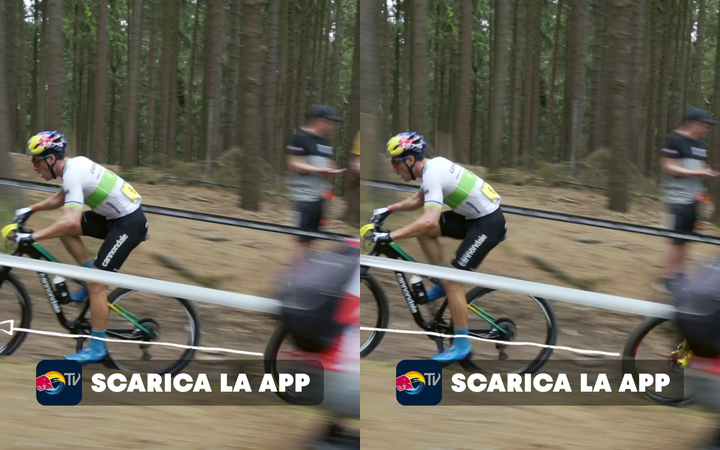

In [46]:
foo = os.path.join(extracted_frames_directory, "UCI", "UCI370.jpg")
img1 = Image.open(foo)
new_size = (img1.width / 3, img1.height / 3)
img1.thumbnail(new_size, Image.ANTIALIAS)
# img1

foo = os.path.join(extracted_frames_directory, "UCI", "UCI371.jpg")
img2 = Image.open(foo)
new_size = (img2.width / 3, img2.height / 3)
img2.thumbnail(new_size, Image.ANTIALIAS)
# img2


dst = Image.new('RGB', (img1.width + img2.width, img1.height))
dst.paste(img1, (0, 0))
dst.paste(img2, (img1.width, 0))
dst

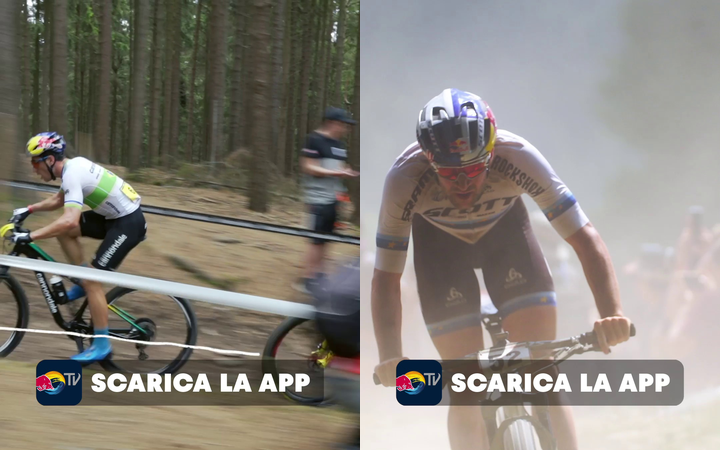

In [47]:
foo = os.path.join(extracted_frames_directory, "UCI", "UCI371.jpg")
img1 = Image.open(foo)
new_size = (img1.width / 3, img1.height / 3)
img1.thumbnail(new_size, Image.ANTIALIAS)
# img1

foo = os.path.join(extracted_frames_directory, "UCI", "UCI372.jpg")
img2 = Image.open(foo)
new_size = (img2.width / 3, img2.height / 3)
img2.thumbnail(new_size, Image.ANTIALIAS)
# img2


dst = Image.new('RGB', (img1.width + img2.width, img1.height))
dst.paste(img1, (0, 0))
dst.paste(img2, (img1.width, 0))
dst

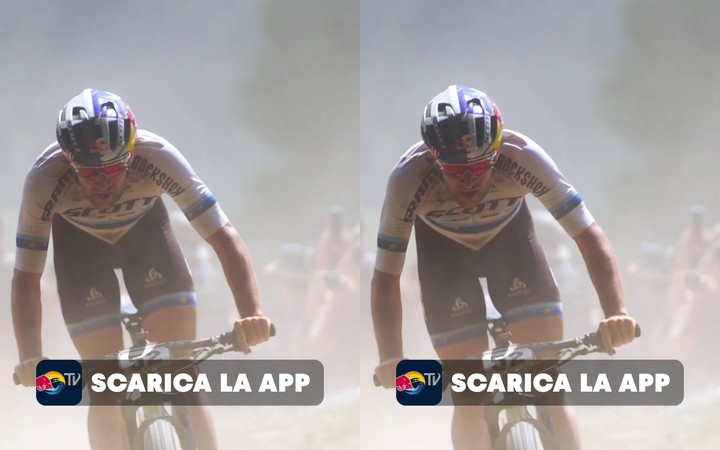

In [48]:
foo = os.path.join(extracted_frames_directory, "UCI", "UCI372.jpg")
img1 = Image.open(foo)
new_size = (img1.width / 3, img1.height / 3)
img1.thumbnail(new_size, Image.ANTIALIAS)
# img1

foo = os.path.join(extracted_frames_directory, "UCI", "UCI373.jpg")
img2 = Image.open(foo)
new_size = (img2.width / 3, img2.height / 3)
img2.thumbnail(new_size, Image.ANTIALIAS)
# img2


dst = Image.new('RGB', (img1.width + img2.width, img1.height))
dst.paste(img1, (0, 0))
dst.paste(img2, (img1.width, 0))
dst

# RESOURCES

- `CV2` General https://www.programcreek.com/python/index/2663/cv2

- `CV2` FPS https://www.programcreek.com/python/example/89372/cv2.CAP_PROP_FPS

- Create dataframe with Directory and Files https://stackoverflow.com/questions/44112286/python-store-directories-and-filenames-as-dataframe-columns

- Natural Sorting https://stackoverflow.com/a/29582718/1399279

- Resize photos to thumbnail https://www.geeksforgeeks.org/python-pil-image-thumbnail-method/

- Display side by side photos https://note.nkmk.me/en/python-pillow-concat-images/